特徴量として、エントロピーと閉じかっこを選択。SQLインジェクションの含まれるhttpクエリ文字列と含まれない文字列で特徴量の違いを確認。

In [1]:
import pandas as pd
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')

In [2]:
import numpy as np
import pandas as pd

# HTTPクエリストリングのエントロピーの計算
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [3]:
# 通常であるとラベリングされた行列のみを抽出
df_norm = df[df.attack_type == 'norm']

# 算出されたエントロピーを格納するリストを用意
norm_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_norm['payload']:
    
    # エントロピーの計算と代入
    norm_entropies.append(H_entropy(i))

In [4]:
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

In [5]:
# SQLインジェクションであるとラベリングされた行列のみを抽出
df_sqli = df[df.attack_type == 'sqli']

# 算出されたエントロピーを格納するリストを用意
sqli_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_sqli['payload']:
    
    # エントロピーの計算と代入
    sqli_entropies.append(H_entropy(i))


In [6]:
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

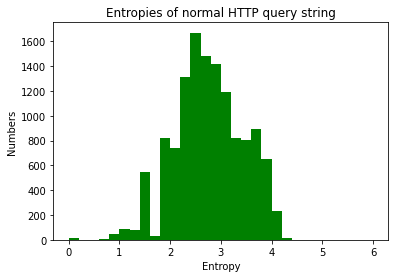

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show()

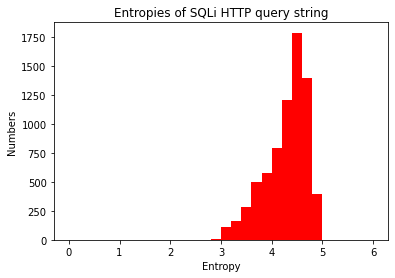

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of SQLi HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show()

In [9]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli

,payload,length,attack_type,label
291,1' where 6406=6406;select count(*) from rdb$fi...,115,sqli,anom
292,1) and 8514=(select count(*) from domain.domai...,111,sqli,anom
293,1) where 7956=7956 or sleep(5)#,31,sqli,anom
294,-7387'))) order by 1--,22,sqli,anom
295,"1))) union all select null,null,null#",37,sqli,anom
...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,anom
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,anom
20362,"1"" order by 1--",15,sqli,anom
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,anom


閉じかっこの存在率(sqli)

In [10]:
print('{:.2%}'.format(
    df_sqli['payload'].str.contains('\)').sum() \
    / len(df_sqli['payload'])
    )
)

90.91%


閉じかっこの存在率(norm)

In [11]:
df_norm = df[df.attack_type == 'norm']
print('{:.2%}'.format(
    df_norm['payload'].str.contains('\)').sum() \
    / len(df_norm['payload'])
    )
)

0.01%


In [12]:
def func_preprocessing(df):
    train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
    df = df[train_rows]

    # エントロピーと閉じ括弧の有無を入れる配列
    entropies = []
    closing_parenthesis = []
    
    # payload列からHTTPクエリストリングを取り出して処理させる
    for i in df['payload']:
        # エントロピーの計算と代入
        entropies.append(H_entropy(i))
        
        # 閉じ括弧を検出して、存在した場合は列closing_parenthesisに1を設定、
        # ない場合は0を設定
        if i.count(')'):
            closing_parenthesis.append(1)
        else:
            closing_parenthesis.append(0)
    
    # データセットに新たに列を追加
    df = df.assign(entropy=entropies)
    df = df.assign(closing_parenthesis=closing_parenthesis)
    
    # データセットのlabel列のnormを0に、anormを1に変更
    rep = df.label.replace({"norm":0,"anom":1})
    df = df.assign(label=rep)
    
    return df

In [13]:
df = func_preprocessing(df)

In [14]:
df

,payload,length,attack_type,label,entropy,closing_parenthesis
0,c/ caridad s/n,14,norm,0,3.093069,0
1,"campello, el",12,norm,0,3.022055,0
2,1442431887503330,16,norm,0,2.827820,0
3,nue37,5,norm,0,2.321928,0
4,tufts3@joll.rs,14,norm,0,3.378783,0
...,...,...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,1,4.064392,1
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,1,4.718866,1
20362,"1"" order by 1--",15,sqli,1,3.189898,0
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,1,4.641613,1


7.4 SQLインジェクション検出器の開発

エントロピーと閉じ括弧の有無を特徴量として検出器を作成。交差検証し汎化性能を評価。

In [15]:
# 交差検証を行うため、テスト用に分割されているデータも読み込んで単一の行列にする
# テストデータのロード
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')
test_data = func_preprocessing(test_data)

# 特徴量に使用する列のみを抽出
df_x = df[['length','entropy','closing_parenthesis']]
test_x = test_data[['length','entropy','closing_parenthesis']]

# ラベルのみを抽出
df_y = df[['label']]
test_y = test_data[['label']]

# 特徴量とラベルとして、それぞれひとつにまとめる
X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

ラベルと特徴量のデータ

In [16]:
X_all

,length,entropy,closing_parenthesis
0,14,3.093069,0
1,12,3.022055,0
2,16,2.827820,0
3,5,2.321928,0
4,14,3.378783,0
...,...,...,...
10176,113,4.422041,1
10177,113,4.514233,1
10178,136,4.630369,1
10179,111,4.539371,1


In [17]:
y_all

,label
0,0
1,0
2,0
3,0
4,0
...,...
10176,1
10177,1
10178,1
10179,1


交差検証(5分割、シャッフルあり)

ハイパーパラメータ探索と交差検証を繰り返し、ハイパーパラメータチューニング

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical(
            'criterion', 
            ['gini', 'entropy']
            ),
        'max_depth': trial.suggest_int(
            'max_depth', 
            1, 64
            )
        }
        model = DecisionTreeClassifier(**params)

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2022-10-06 08:09:35,074] A new study created in memory with name: no-name-92f1a6e5-b710-45ac-a9b0-191440b3b177
[I 2022-10-06 08:09:36,310] Trial 0 finished with value: 0.9807246410434873 and parameters: {'criterion': 'entropy', 'max_depth': 19}. Best is trial 0 with value: 0.9807246410434873.
[I 2022-10-06 08:09:37,133] Trial 1 finished with value: 0.9843310391049931 and parameters: {'criterion': 'entropy', 'max_depth': 7}. Best is trial 0 with value: 0.9807246410434873.
[I 2022-10-06 08:09:37,925] Trial 2 finished with value: 0.9799784669055412 and parameters: {'criterion': 'entropy', 'max_depth': 39}. Best is trial 2 with value: 0.9799784669055412.
[I 2022-10-06 08:09:38,590] Trial 3 finished with value: 0.9824656424268984 and parameters: {'criterion': 'gini', 'max_depth': 10}. Best is trial 2 with value: 0.9799784669055412.
[I 2022-10-06 08:09:38,622] Trial 4 finished with value: 0.9801442786069652 and parameters: {'criterion': 'gini', 'max_depth': 42}. Best is trial 2 with value

params: {'criterion': 'entropy', 'max_depth': 1}


訓練・評価とその結果(正解率)

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 訓練の実施
model = DecisionTreeClassifier(
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth']
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 96.71751 %
[[3847    0]
 [ 198 1987]]


In [20]:
X_test

,length,entropy,closing_parenthesis
6743,5,2.321928,0
17099,9,2.947703,0
4953,27,3.689892,0
5954,11,2.913977,0
16132,6,2.584963,0
...,...,...,...
16126,7,2.235926,0
5887,9,2.503258,0
1246,9,2.725481,0
8684,27,3.838040,0
